

From: Shilpi

In [2]:
import warnings
warnings.filterwarnings('ignore')

from sigpyproc.readers import FilReader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import dates
import matplotlib.dates as mdates
from datetime import datetime
import astropy.units as u
from astropy.time import Time
from astropy.visualization import ImageNormalize, PercentileInterval

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

print(plt.get_backend())

module://matplotlib_inline.backend_inline


In [3]:
path = '/home/mnedal/data/ilofar'
filename = f'{path}/Sun357_20240514_stokesI.fil'

In [3]:
a = FilReader(filename) # header
header = a.header.to_dict()

In [53]:
header

{'filename': '/home/mnedal/data/ilofar/Sun357_20240514_stokesI.fil',
 'data_type': 'filterbank',
 'nchans': 488,
 'foff': -0.1953125,
 'fch1': 200.0,
 'nbits': 32,
 'tsamp': 0.00131072,
 'tstart': 60444.418055551,
 'nsamples': 24902343,
 'nifs': 1,
 'coord': <SkyCoord (ICRS): (ra, dec) in deg
     (0., 0.)>,
 'azimuth': <Angle 297.27495739 deg>,
 'zenith': <Angle 52.16498088 deg>,
 'telescope': 'MeerKAT',
 'backend': 'FAKE',
 'source': 'Sun357',
 'frame': 'topocentric',
 'ibeam': 0,
 'nbeams': 0,
 'dm': 0,
 'period': 0,
 'accel': 0,
 'signed': False,
 'rawdatafile': 'unknown',
 'stream_info': {'entries': [{'filename': '/home/mnedal/data/ilofar/Sun357_20240514_stokesI.fil',
    'hdrlen': 347,
    'datalen': 48609373536,
    'nsamples': 24902343,
    'tstart': 60444.418055551,
    'tsamp': 0.00131072}]},
 'basename': 'Sun357_20240514_stokesI',
 'extension': '.fil',
 'telescope_id': 64,
 'machine_id': 0,
 'bandwidth': 95.3125,
 'ftop': 200.09765625,
 'fbottom': 104.78515625,
 'fcenter': 1

In [6]:
# 2024-05-14 16:35 - 17:45 UT

In [9]:
tstart_obs_str = Time(a.header.tstart, format='mjd').iso
tstart = datetime.strptime(tstart_obs_str, '%Y-%m-%d %H:%M:%S.%f')

tstart_str = '2024-05-14 16:35:00'
tend_str   = '2024-05-14 17:45:00'
datetime1 = datetime.strptime(tstart_str, '%Y-%m-%d %H:%M:%S')
datetime2 = datetime.strptime(tend_str, '%Y-%m-%d %H:%M:%S')

print(tstart, datetime1, datetime2, sep='\n')

time_difference1 = datetime1 - tstart
time_difference2 = datetime2 - datetime1

secondsFromStart = time_difference1.total_seconds()
totalTime = time_difference2.total_seconds()

print(secondsFromStart, totalTime, sep='\n')

2024-05-14 10:02:00
2024-05-14 16:35:00
2024-05-14 17:45:00
23580.0
4200.0


In [10]:
# downsampling the data to time resolution of 0.5 s. the time resolution to 0.5 s > 500 ms. And 500/1.31 ms = ~381. So tfactor should be 381.
data = a.read_block(int(secondsFromStart / a.header.tsamp), int(totalTime / a.header.tsamp))
# np.save(f'{path}/realta_ilofar.npy', data)

In [157]:
# data.nbytes/(1024*1024*1024) # data size in GB

5.825312286615372

In [168]:
print(data.shape, data.shape[1]*a.header.tsamp, sep='\n')

(488, 3204345)
4199.9990784


In [173]:
# [x for x in dir(data) if not x.startswith('_')]

In [201]:
Tres = 7                # time resolution of 7 millisecond
tres = a.header.tsamp*1e3 # time resolution in header

data2 = data.downsample(tfactor = int(Tres/tres)) # downsampling data applied by summing sequential sample/channels and averaging the data
np.save(f'{path}/res_0.1sec_ilofar.npy', data2)

In [202]:
data2.shape

(488, 640869)

In [205]:
# Creating time axis for 0.5 s
tstart = Time(data.header.tstart, format='mjd')              # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
tarray = tstart + (np.arange(data2.shape[1])*(Tres/1000)*u.s) # Creating the time array for 0.5 time res.

Tarray = []
for i in range(tarray.shape[0]):
	Tarray.append(datetime.strptime(tarray[i].iso, '%Y-%m-%d %H:%M:%S.%f')) # Converting the array to datetime object

Tarray = np.array(Tarray)
np.save(f'{path}/time_0.1sec.npy', Tarray)

In [212]:
print(Tarray[1] - Tarray[0], Tarray[-1] - Tarray[-2], sep='\n')

0:00:00.007000
0:00:00.007000


In [209]:
Tarray[1], Tarray[0]

(datetime.datetime(2024, 5, 14, 16, 35, 0, 6000),
 datetime.datetime(2024, 5, 14, 16, 34, 59, 999000))

In [217]:
# Creating time axis for realta time res of 1.31ms
realta_time = tstart + (np.arange(data.shape[1])*data.header.tsamp*u.s) # Creating the time array for realta time resolution

realta_T = []
for i in range(realta_time.shape[0]):
	realta_T.append(datetime.strptime(realta_time[i].iso, '%Y-%m-%d %H:%M:%S.%f')) # Converting the array to datetime object

realta_T = np.array(realta_T)
np.save(f'{path}/realta_time.npy', realta_T)

In [218]:
realta_T.shape

(3204345,)

In [219]:
print(realta_T[1] - realta_T[0], realta_T[-1] - realta_T[-2], sep='\n')

0:00:00.002000
0:00:00.001000


In [221]:
realta_T[1], realta_T[-1]

(datetime.datetime(2024, 5, 14, 16, 35, 0, 1000),
 datetime.datetime(2024, 5, 14, 17, 44, 59, 997000))

In [56]:
data.shape[1]

3204345

In [54]:
# find all the possible tfactor values that would work
good_tfactor = []
tres = a.header.tsamp*1e3

for x in range(1, data.shape[1]):
    tfactor = round(x/tres)
    if data.shape[1] % tfactor == 0:
        good_tfactor.append(x)
    else:
        pass

print(len(good_tfactor))

8


In [58]:
good_tfactor

[1, 4, 6, 7, 20, 280000, 840000, 1400000]

In [59]:
Tres = 20                 # time resolution of 0.02 millisecond
tres = a.header.tsamp*1e3 # time resolution in header

data3 = data.downsample(tfactor = int(Tres/tres)) # downsampling data applied by summing sequential sample/channels and averaging the data
data3.shape

(488, 213623)

In [61]:
# 1000 --> 1 s
# 100  --> 0.1 s
# 10   --> 0.01 s

In [62]:
np.save(f'{path}/res_0.02sec_ilofar.npy', data3)

In [64]:
# Creating time axis for 0.02 s
tstart = Time(data.header.tstart, format='mjd')              # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
tarray = tstart + (np.arange(data3.shape[1])*(Tres/1000)*u.s) # Creating the time array for 0.5 time res.

Tarray3 = []
for i in range(tarray.shape[0]):
	Tarray3.append(datetime.strptime(tarray[i].iso, '%Y-%m-%d %H:%M:%S.%f')) # Converting the array to datetime object

Tarray3 = np.array(Tarray3)
np.save(f'{path}/time_0.02sec.npy', Tarray3)

In [104]:
freqs3 = data3.header.chan_freqs
np.save(f'{path}/freq.npy', freqs3)

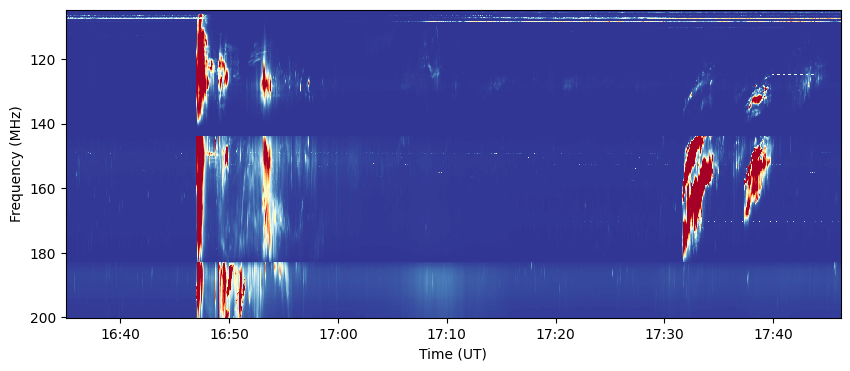

In [66]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)

ax.pcolormesh(Tarray3, freqs3, data3,
              norm=ImageNormalize(data3, interval=PercentileInterval(97)),
              cmap='RdYlBu_r')

# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1]) # Reverse the y-axis
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

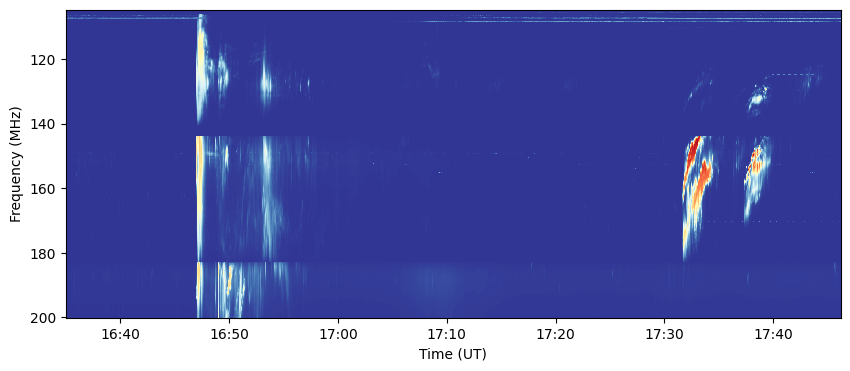

In [84]:
freqs3 = data3.header.chan_freqs

from matplotlib.colors import Normalize

fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)

ax.pcolormesh(Tarray3, freqs3, data3,
              norm=Normalize(vmin=np.min(data3), vmax=np.max(data3)),
              cmap='RdYlBu_r')

# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1]) # Reverse the y-axis
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

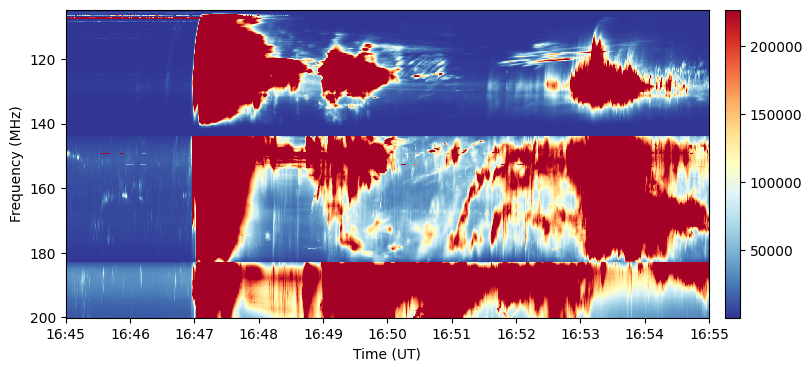

In [5]:
data = np.load(f'{path}/res_0.02sec_ilofar.npy')
time = np.load(f'{path}/time_0.02sec.npy', allow_pickle=True)
freqs = np.load(f'{path}/freq.npy')

fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)

img = ax.pcolormesh(time, freqs, data,
              norm=ImageNormalize(data, interval=PercentileInterval(88)),
              cmap='RdYlBu_r')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim(left=pd.Timestamp('2024-05-14 16:45'),
            right=pd.Timestamp('2024-05-14 16:55'))
fig.colorbar(img, pad=0.02)
plt.show()

In [31]:
time[37000:38000][-1], data.shape

(datetime.datetime(2024, 5, 14, 16, 47, 39, 979000), (488, 213623))

In [28]:
# The datetime you want to find or find the nearest to
target_datetime = datetime(2024, 5, 14, 16, 47, 30)

# Find the nearest datetime
nearest_datetime = min(time, key=lambda dt: abs(dt - target_datetime))

# Find the index of the nearest datetime
nearest_index = list(time).index(nearest_datetime)
nearest_index

37500

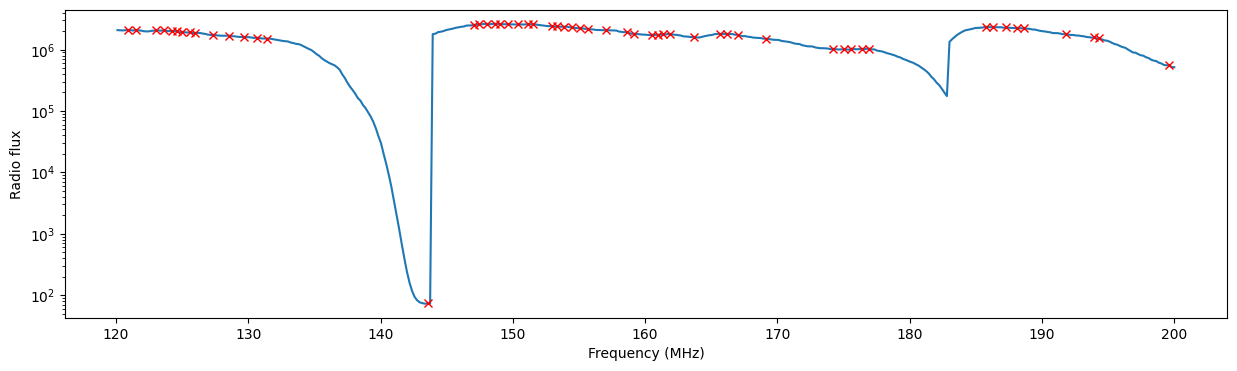

In [143]:
from scipy.signal import find_peaks

nearest_freq_index1 = np.abs(freqs - 120).argmin()
nearest_freq_index2 = np.abs(freqs - 200).argmin()

freqs_slice = freqs[nearest_freq_index2 : nearest_freq_index1]
data_slice = data[nearest_freq_index2 : nearest_freq_index1, nearest_index]
# data_slice = data[nearest_freq_index2 : nearest_freq_index1, 40000]

# Finding peaks in the inverted data
peaks = find_peaks(data_slice)[0]

# Extracting the indices of the two most prominent negative peaks
# negative_peak_indices = peaks[np.argsort(data_slice[peaks])[:2]]
negative_peak_indices = peaks[np.argsort(data_slice[peaks])]

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)
ax.plot(freqs_slice, data_slice)
plt.plot(freqs_slice[negative_peak_indices], data_slice[negative_peak_indices], 'rx')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Radio flux')
plt.show()

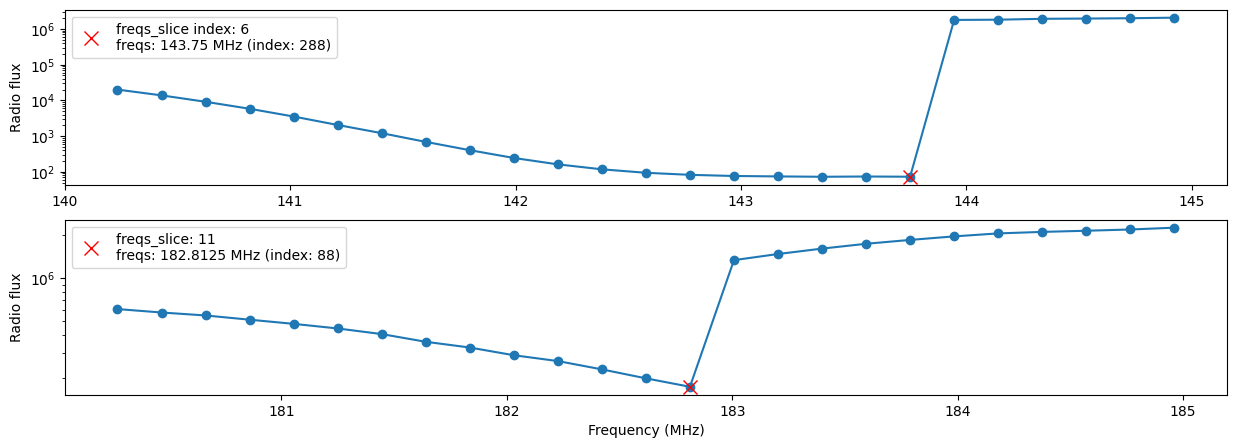

In [162]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(211)
nearest_freq_index1 = np.abs(freqs - 140).argmin()
nearest_freq_index2 = np.abs(freqs - 145).argmin()
freqs_slice = freqs[nearest_freq_index2 : nearest_freq_index1]
data_slice = data[nearest_freq_index2 : nearest_freq_index1, nearest_index]
peaks1 = find_peaks(data_slice)[0]
negative_peak_indices = peaks1[np.argsort(data_slice[peaks1])]-1 # the one is an offset

ax.plot(freqs_slice, data_slice, '-o')
ax.plot(freqs_slice[negative_peak_indices], data_slice[negative_peak_indices], 'rx', ms=10,
        label=f'freqs_slice index: {negative_peak_indices[0]}\nfreqs: {freqs[nearest_freq_index2+negative_peak_indices][0]} MHz (index: {nearest_freq_index2+negative_peak_indices[0]})')
ax.set_yscale('log')
ax.set_ylabel('Radio flux')
ax.legend()

ax = fig.add_subplot(212)
nearest_freq_index1 = np.abs(freqs - 180).argmin()
nearest_freq_index2 = np.abs(freqs - 185).argmin()
freqs_slice = freqs[nearest_freq_index2 : nearest_freq_index1]
data_slice = data[nearest_freq_index2 : nearest_freq_index1, nearest_index]
peaks2 = find_peaks(data_slice)[0]
negative_peak_indices = peaks2[np.argsort(data_slice[peaks2])]

ax.plot(freqs_slice, data_slice, '-o')
second_index = 11
ax.plot(freqs_slice[second_index], data_slice[second_index], 'rx', ms=10,
        label=f'freqs_slice: {second_index}\nfreqs: {freqs[nearest_freq_index2+second_index]} MHz (index: {nearest_freq_index2+second_index})')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Radio flux')
ax.legend()
plt.show()

# Since the code couldn't detect that negative peak in the second segment, I would define its index manually.

In [163]:
np.abs(freqs-182.8).argmin()

88

In [125]:
freqs[88], freqs[87]

(182.8125, 183.0078125)

In [108]:
freqs[102+11]

177.9296875

In [96]:
freqs[nearest_freq_index2 + negative_peak_indices][0]

143.5546875

In [100]:
freqs[256+33]

143.5546875

In [98]:
negative_peak_indices

array([33])

In [107]:
nearest_freq_index1

102

In [164]:
gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))

In [165]:
gap1

array([166.40625 , 166.015625, 165.625   , 165.234375, 164.84375 ,
       164.453125, 164.0625  , 163.671875, 163.28125 , 162.890625,
       162.5     , 162.109375, 161.71875 , 161.328125, 160.9375  ,
       160.546875, 160.15625 , 159.765625, 159.375   , 158.984375,
       158.59375 , 158.203125, 157.8125  , 157.421875, 157.03125 ,
       156.640625, 156.25    , 155.859375, 155.46875 , 155.078125,
       154.6875  , 154.296875, 153.90625 , 153.515625, 153.125   ,
       152.734375, 152.34375 , 151.953125, 151.5625  , 151.171875,
       150.78125 , 150.390625, 150.      , 149.609375, 149.21875 ,
       148.828125, 148.4375  , 148.046875, 147.65625 , 147.265625,
       146.875   , 146.484375, 146.09375 , 145.703125, 145.3125  ,
       144.921875, 144.53125 , 144.140625, 143.75    ])

In [166]:
gap2

array([204.6875  , 204.296875, 203.90625 , 203.515625, 203.125   ,
       202.734375, 202.34375 , 201.953125, 201.5625  , 201.171875,
       200.78125 , 200.390625, 200.      , 199.609375, 199.21875 ,
       198.828125, 198.4375  , 198.046875, 197.65625 , 197.265625,
       196.875   , 196.484375, 196.09375 , 195.703125, 195.3125  ,
       194.921875, 194.53125 , 194.140625, 193.75    , 193.359375,
       192.96875 , 192.578125, 192.1875  , 191.796875, 191.40625 ,
       191.015625, 190.625   , 190.234375, 189.84375 , 189.453125,
       189.0625  , 188.671875, 188.28125 , 187.890625, 187.5     ,
       187.109375, 186.71875 , 186.328125, 185.9375  , 185.546875,
       185.15625 , 184.765625, 184.375   , 183.984375, 183.59375 ,
       183.203125, 182.8125  ])

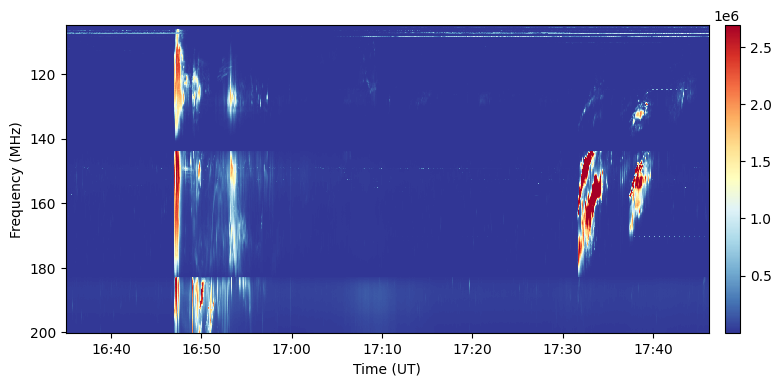

In [128]:
data = np.load(f'{path}/res_0.02sec_ilofar.npy')
time = np.load(f'{path}/time_0.02sec.npy', allow_pickle=True)
freqs = np.load(f'{path}/freq.npy')

fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)

img = ax.pcolormesh(time, freqs, data,
              vmin=np.percentile(data, 1), vmax=np.percentile(data, 99.7),
              cmap='RdYlBu_r')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(img, pad=0.02)
plt.show()

In [168]:
[mdates.date2num(t) for t in time]

[19857.69097221065,
 19857.69097244213,
 19857.690972673612,
 19857.690972905093,
 19857.690973136574,
 19857.690973368055,
 19857.690973599536,
 19857.690973831017,
 19857.690974062498,
 19857.69097429398,
 19857.690974525463,
 19857.690974756944,
 19857.690974988425,
 19857.69097521991,
 19857.69097545139,
 19857.69097568287,
 19857.690975914353,
 19857.690976145834,
 19857.690976377315,
 19857.690976608796,
 19857.690976840277,
 19857.690977071758,
 19857.69097730324,
 19857.690977534723,
 19857.690977766204,
 19857.690977997685,
 19857.690978229166,
 19857.690978460647,
 19857.69097869213,
 19857.690978923612,
 19857.690979155093,
 19857.690979386574,
 19857.690979618055,
 19857.690979849536,
 19857.690980081017,
 19857.690980312498,
 19857.690980543983,
 19857.690980775464,
 19857.690981006945,
 19857.690981238426,
 19857.690981469907,
 19857.690981701387,
 19857.69098193287,
 19857.690982164353,
 19857.690982395834,
 19857.690982627315,
 19857.690982858796,
 19857.690983090277,
 

In [169]:
def freq_axis(freqs):
    gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
    gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))
    ax_shape = 59+57-1
    new_freq = np.zeros(ax_shape+freqs.shape[0])
    
    new_freq[0:88] = freqs[0:88]
    new_freq[88:145]  = gap2[:57]
    new_freq[145:345] = freqs[88:288]
    new_freq[345:404] = gap1[:59]
    new_freq[404:] = freqs[289:]
    
    return new_freq



def plot_ilofarspectro(data, time, freqs, ax):
	
    new_freq = freq_axis(freqs)
    
    data = np.log10(data)
    data[np.where(np.isinf(data)==True)] = 0.0
    
    data2 = np.empty((new_freq.shape[0], data.shape[1]))    
    data2[:] = np.NaN
    data2[0:88] = data[0:88]
    data2[145:345] = data[88:288]
    data2[404:] = data[289:]
    
    times_mpl = [mdates.date2num(t) for t in time]
    
    ax.pcolormesh(times_mpl, new_freq, data2,
                  vmin=np.percentile(data, 1), vmax=np.percentile(data, 99.7),
                  cmap=plt.get_cmap('RdYlBu_r'))
    
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Frequency (MHz)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # ax.set_ylim(new_freq[0], 10.7421875)
    # ax.invert_yaxis()
    # ax.set_ylim(ax.get_ylim()[::-1])
    # plt.show()
    
    return (data, freqs)

In [106]:
data = np.load(f'{path}/res_0.02sec_ilofar.npy')
time = np.load(f'{path}/time_0.02sec.npy', allow_pickle=True)
freqs = np.load(f'{path}/freq.npy')

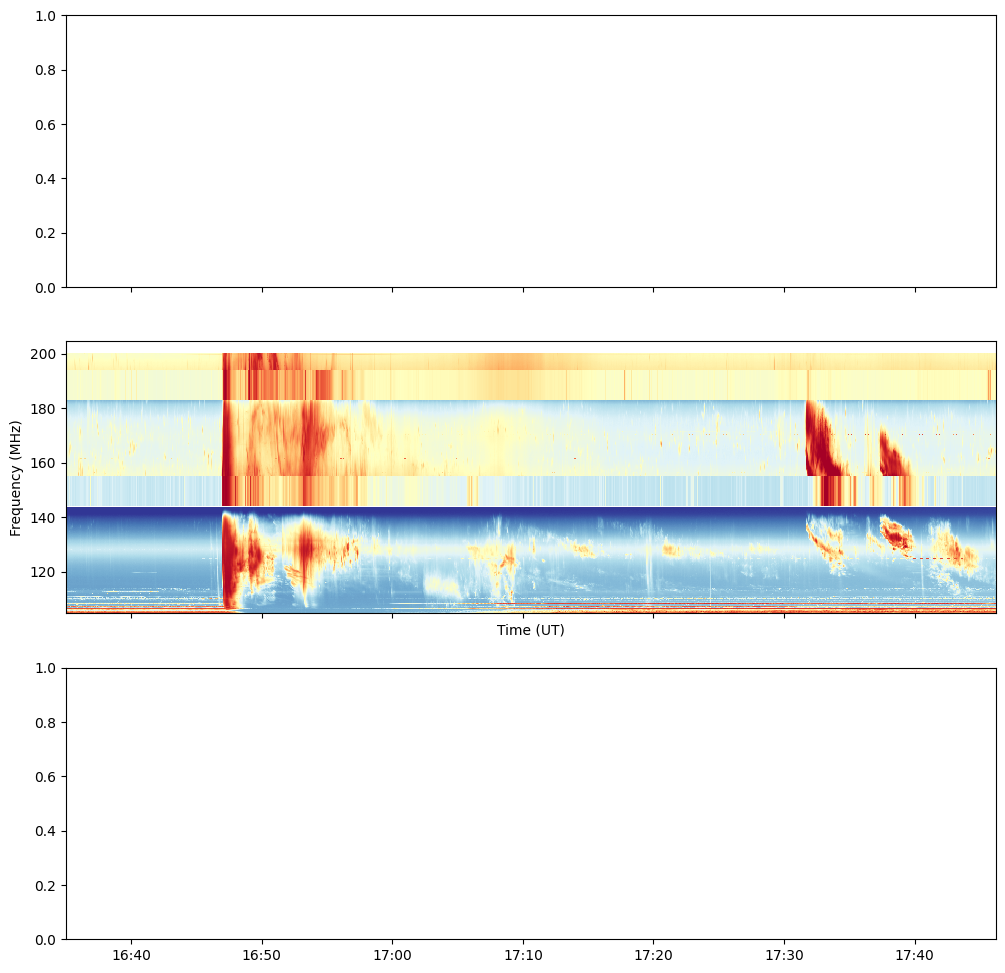

In [170]:
# set up the plots 3 rows 1 column with shared common x-axis
fig, axes = plt.subplots(3, 1, sharex=True, figsize=[12,12])
# plt.subplots_adjust(hspace=0.05)
data, freqs = plot_ilofarspectro(data, time, freqs, axes[1])

In [171]:
new_freq = freq_axis(freqs)

data = np.log10(data)
data[np.where(np.isinf(data)==True)] = 0.0

data2 = np.empty((new_freq.shape[0], data.shape[1]))    
data2[:] = np.NaN
data2[0:88] = data[0:88]
data2[145:345] = data[88:288]
data2[404:] = data[289:]

times_mpl = [mdates.date2num(t) for t in time]

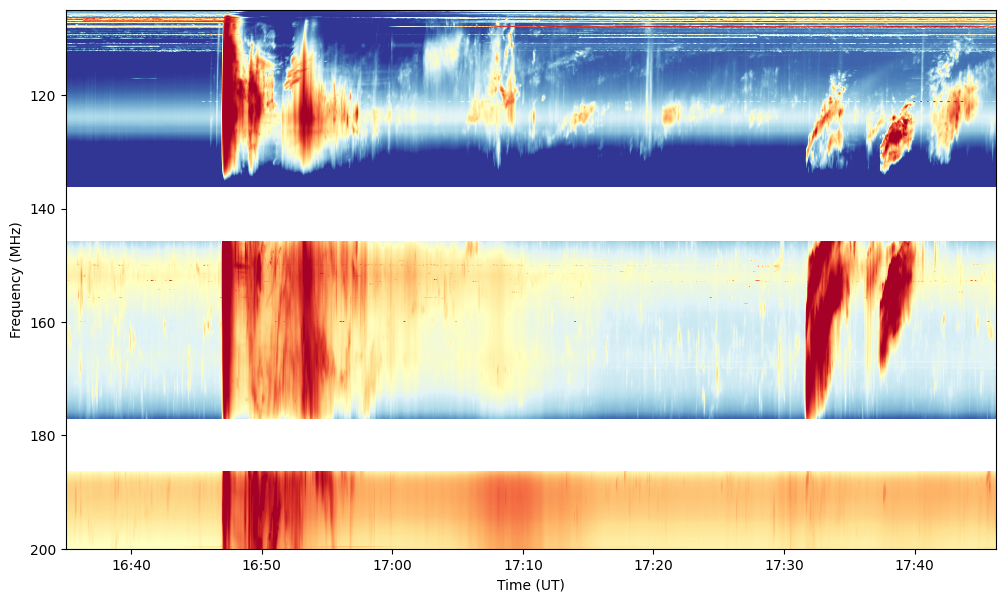

In [186]:
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
img = ax.imshow(data2, aspect='auto', origin='lower',
          vmin=np.percentile(data, 10), vmax=np.percentile(data, 98),
            extent=[times_mpl[0], times_mpl[-1],
                    new_freq[0], new_freq[-1]],
            cmap='RdYlBu_r')
# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(img)
plt.show()

In [207]:
freq_mode3 = np.linspace(10, 90, 199)
freq_mode5 = np.linspace(110, 190, 200)
freq_mode7 = np.linspace(210, 270, 88)

mode3 = {'time': times_mpl,
         'freq': freq_mode3[::-1],
         'data': data2[404:]}

mode5 = {'time': times_mpl,
         'freq': freq_mode5[::-1],
         'data': data2[145:345]}

mode7 = {'time': times_mpl,
         'freq': freq_mode7[::-1],
         'data': data2[0:88]}

In [236]:
from matplotlib.colors import LogNorm

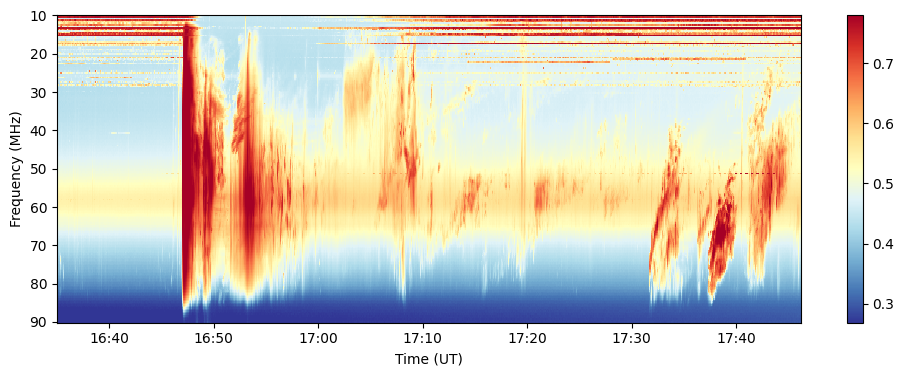

In [243]:
fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(111)
img = ax.pcolormesh(mode3['time'], mode3['freq'], mode3['data'],
                    # norm=LogNorm(vmin=np.percentile(mode3['data'], 1), vmax=np.percentile(mode3['data'], 99)),
                    vmin=np.percentile(mode3['data'], 1), vmax=np.percentile(mode3['data'], 99),
                    cmap='RdYlBu_r')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(img)
plt.show()

In [250]:
mode3['data'].shape, log_freqs.shape

((199, 213623), (199,))

In [285]:
data = mode3['data'][:, 160000:]
time = mode3['time'][160000:]
freqs = mode3['freq']

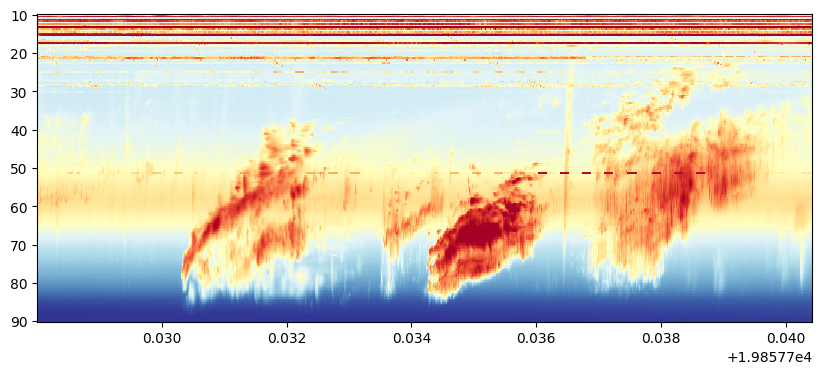

In [286]:
fig = plt.figure(figsize=[7,4])
ax = fig.add_subplot(111)
ax.pcolormesh(time, freqs, data,
                    vmin=np.percentile(data, 1), vmax=np.percentile(data, 99),
                    cmap='RdYlBu_r')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

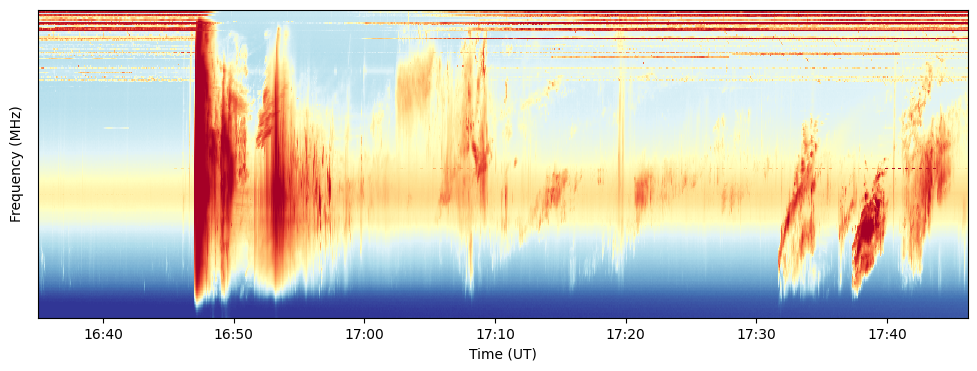

In [258]:
fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(111)

# ax.set_yscale('log')

ax.pcolormesh(mode3['time'], mode3['freq'], mode3['data'],
                    vmin=np.percentile(mode3['data'], 1), vmax=np.percentile(mode3['data'], 99),
                    cmap='RdYlBu_r')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')

# Get y-axis limits after applying log scale
y_min, y_max = ax.get_ylim()

# Mimic y-axis ticks from the example image (replace with your values)
xticks = mode3['freq']
ax.set_yticks(np.power(10, np.array(xticks)))  # Convert tick values to log scale

# Set y-axis labels (replace with labels from the example image)
ax.set_ylabel('Frequency (MHz)', labelpad=10)  # Adjust labelpad for better positioning
ax.set_yticklabels([str(x) for x in xticks])

ax.set_ylim(y_min, y_max)  # Restore original y-axis limits (optional)

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

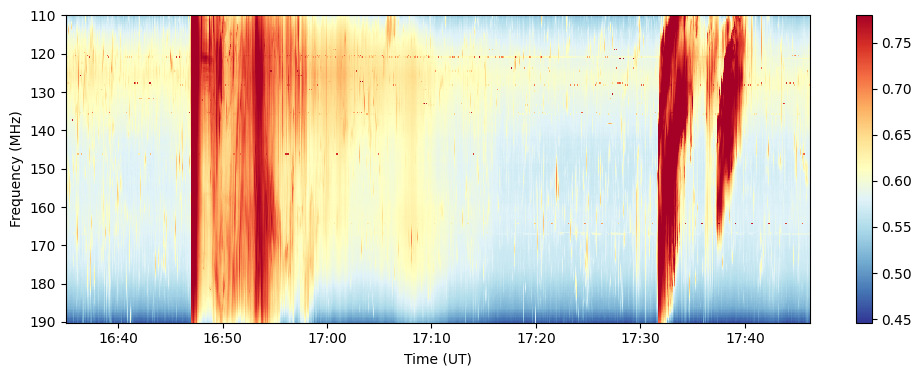

In [212]:
fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(111)
img = ax.pcolormesh(mode5['time'], mode5['freq'], mode5['data'],
                    vmin=np.percentile(data, 10), vmax=np.percentile(data, 98),
                    cmap='RdYlBu_r')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(img)
plt.show()

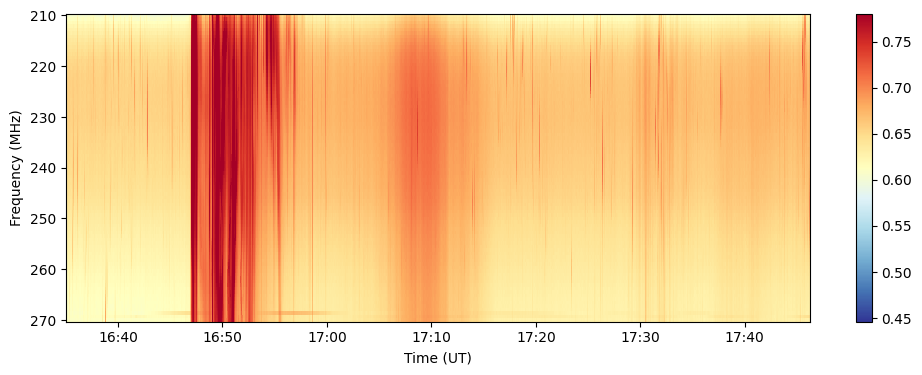

In [213]:
fig = plt.figure(figsize=[12,4])
ax = fig.add_subplot(111)
img = ax.pcolormesh(mode7['time'], mode7['freq'], mode7['data'],
                    vmin=np.percentile(data, 10), vmax=np.percentile(data, 98),
                    cmap='RdYlBu_r')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(img)
plt.show()

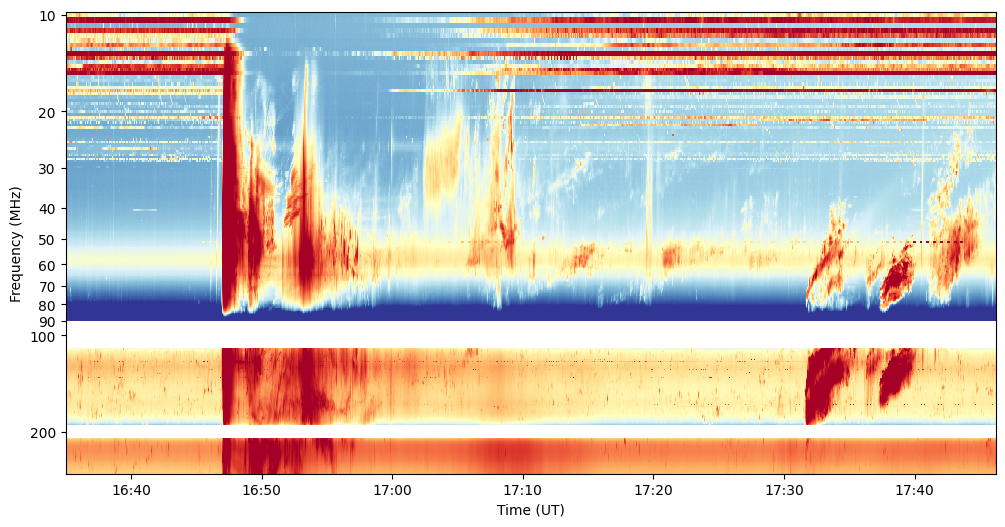

In [336]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(mode3['time'], mode3['freq'], mode3['data'],
                    vmin=np.percentile(data, 10), vmax=np.percentile(data, 98),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode5['time'], mode5['freq'], mode5['data'],
                    vmin=np.percentile(data, 10), vmax=np.percentile(data, 98),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode7['time'], mode7['freq'], mode7['data'],
                    vmin=np.percentile(data, 10), vmax=np.percentile(data, 98),
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [1]:
mode3_new = mode3['data'] - np.tile(np.mean(mode3['data'],0), (mode3['data'].shape[0],1))
mode5_new = mode5['data'] - np.tile(np.mean(mode5['data'],0), (mode5['data'].shape[0],1))
mode7_new = mode7['data'] - np.tile(np.mean(mode7['data'],0), (mode7['data'].shape[0],1))



fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(mode3['time'], mode3['freq'], mode3_new,
                    vmin=np.percentile(mmode3_new, 10), vmax=np.percentile(mode3_new, 98),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode5['time'], mode5['freq'], mode5_new,
                    vmin=np.percentile(mode5_new, 10), vmax=np.percentile(mmode5_new, 98),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode7['time'], mode7['freq'], mode7_new,
                    vmin=np.percentile(mode7_new, 10), vmax=np.percentile(mode7_new, 98),
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

NameError: name 'mode3' is not defined

In [340]:
df_mode3 = pd.DataFrame(data=mode3['data'].T, index=mode3['time'], columns=mode3['freq'])
df_mode5 = pd.DataFrame(data=mode5['data'].T, index=mode3['time'], columns=mode5['freq'])
df_mode7 = pd.DataFrame(data=mode7['data'].T, index=mode3['time'], columns=mode7['freq'])

In [341]:
# Concatenate the dataframes along the columns
combined_df = pd.concat([df_mode3, df_mode5, df_mode7], axis=1)
combined_df.shape

(213623, 487)

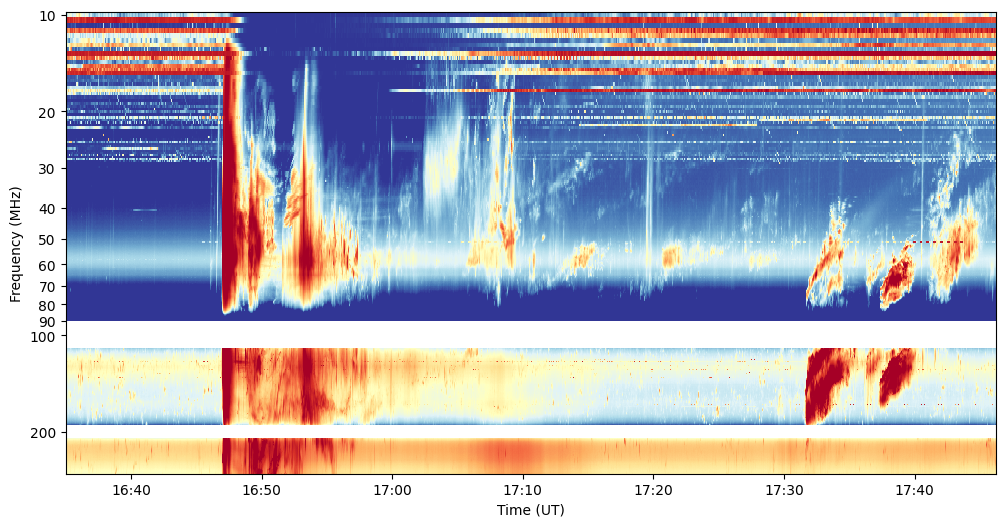

In [343]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(mode3['time'], mode3['freq'], mode3['data'],
                    vmin=np.percentile(combined_df, 10), vmax=np.percentile(combined_df, 98),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode5['time'], mode5['freq'], mode5['data'],
                    vmin=np.percentile(combined_df, 10), vmax=np.percentile(combined_df, 98),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode7['time'], mode7['freq'], mode7['data'],
                    vmin=np.percentile(combined_df, 10), vmax=np.percentile(combined_df, 98),
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [299]:
len(np.hstack((mode3['freq'], mode5['freq'], mode7['freq'])))

487

In [301]:
mode3['data'].shape

(199, 213623)

In [325]:
df_mode3.shape, df_mode5.shape, df_mode7.shape

((213623, 199), (213623, 200), (213623, 88))

In [323]:
combined_df = df_mode3.join(df_mode5, how='outer').join(df_mode7, how='outer')
combined_df.shape

(213623, 487)

In [326]:
combined_df = df_mode3.merge(df_mode5, how='outer', left_index=True, right_index=True)\
                 .merge(df_mode7, how='outer', left_index=True, right_index=True)
combined_df.shape

(213623, 487)

In [327]:
combined_df = pd.concat([df_mode3, df_mode5, df_mode7], axis=1, join='outer')
combined_df.shape

(213623, 487)

In [322]:
199 + 200 + 88

487

In [318]:
combined_df.columns.values

array([ 90.        ,  89.5959596 ,  89.19191919,  88.78787879,
        88.38383838,  87.97979798,  87.57575758,  87.17171717,
        86.76767677,  86.36363636,  85.95959596,  85.55555556,
        85.15151515,  84.74747475,  84.34343434,  83.93939394,
        83.53535354,  83.13131313,  82.72727273,  82.32323232,
        81.91919192,  81.51515152,  81.11111111,  80.70707071,
        80.3030303 ,  79.8989899 ,  79.49494949,  79.09090909,
        78.68686869,  78.28282828,  77.87878788,  77.47474747,
        77.07070707,  76.66666667,  76.26262626,  75.85858586,
        75.45454545,  75.05050505,  74.64646465,  74.24242424,
        73.83838384,  73.43434343,  73.03030303,  72.62626263,
        72.22222222,  71.81818182,  71.41414141,  71.01010101,
        70.60606061,  70.2020202 ,  69.7979798 ,  69.39393939,
        68.98989899,  68.58585859,  68.18181818,  67.77777778,
        67.37373737,  66.96969697,  66.56565657,  66.16161616,
        65.75757576,  65.35353535,  64.94949495,  64.54

In [315]:
combined_df.index[0], combined_df.index[-1], combined_df.columns[0], combined_df.columns[-1]

(19857.69097221065, 19857.740421747683, 90.0, 210.0)

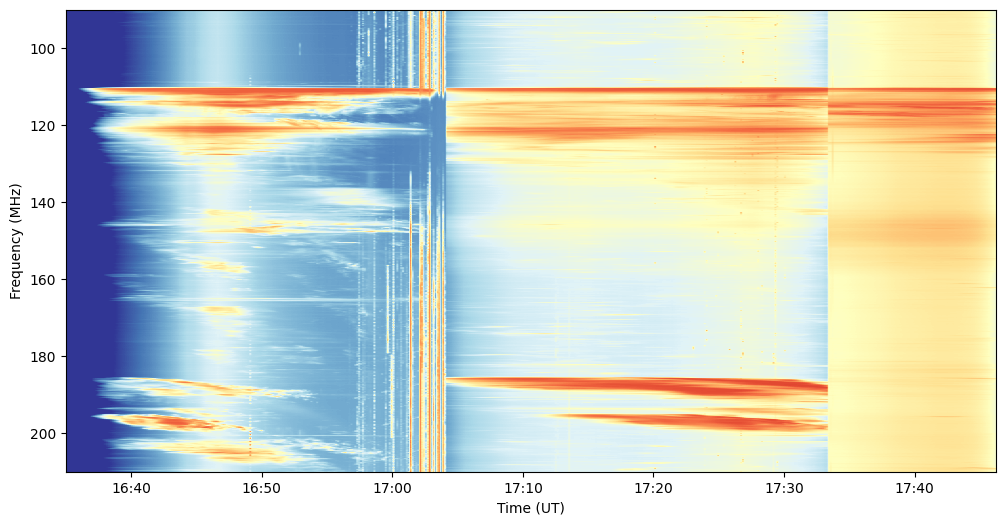

In [320]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
# ax.pcolormesh(combined_df.index.values,
#               combined_df.columns.values,
#               combined_df.values,
#               vmin=np.percentile(combined_df.values, 1), vmax=np.percentile(combined_df.values, 99),
#               cmap='RdYlBu_r')

ax.imshow(combined_df.values, aspect='auto', origin='lower',
            vmin=np.mean(combined_df.values)-2 * np.std(combined_df.values),
            vmax=np.mean(combined_df.values)+3 * np.std(combined_df.values),
            extent=[combined_df.index.values[0], combined_df.index.values[-1], 
                    combined_df.columns.values[0], combined_df.columns.values[-1]],
          cmap='RdYlBu_r')

# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

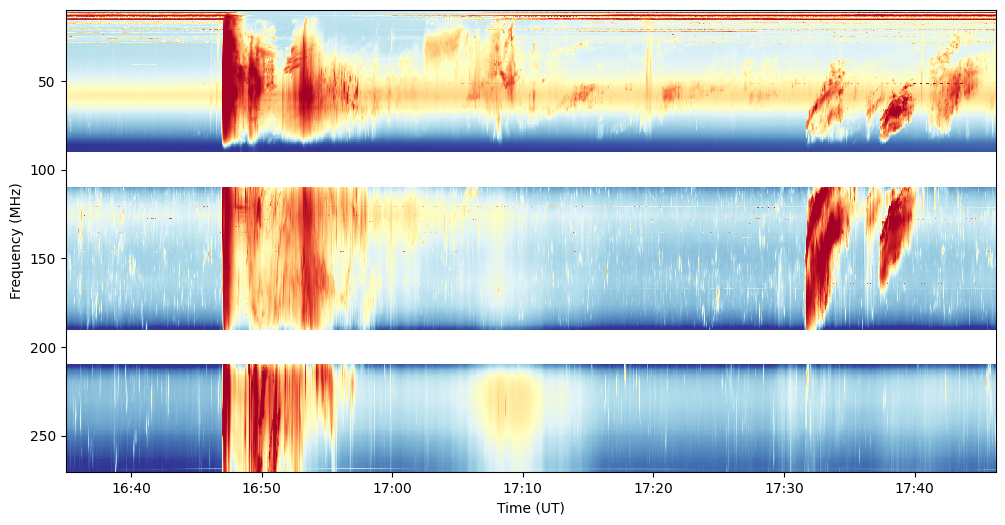

In [287]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(mode3['time'], mode3['freq'], mode3['data'],
                    vmin=np.percentile(mode3['data'], 1), vmax=np.percentile(mode3['data'], 99),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode5['time'], mode5['freq'], mode5['data'],
                    vmin=np.percentile(mode5['data'], 1), vmax=np.percentile(mode5['data'], 99),
                    cmap='RdYlBu_r')
ax.pcolormesh(mode7['time'], mode7['freq'], mode7['data'],
                    vmin=np.percentile(mode7['data'], 1), vmax=np.percentile(mode7['data'], 99),
                    cmap='RdYlBu_r')
# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [289]:
mdates.num2date(mode3['time'][0]), mdates.num2date(mode3['time'][1])

(datetime.datetime(2024, 5, 14, 16, 34, 59, 999000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 5, 14, 16, 35, 0, 19000, tzinfo=datetime.timezone.utc))

In [292]:
(dates.num2date(mode3['time'][1]) - dates.num2date(mode3['time'][0])).total_seconds()

0.02

In [293]:
0.02*1000

20.0

In [218]:
df_mode3 = pd.DataFrame(data=data2[404:].T, index=times_mpl, columns=freq_mode3[::-1])
df_mode5 = pd.DataFrame(data=data2[145:345].T, index=times_mpl, columns=freq_mode5[::-1])
df_mode7 = pd.DataFrame(data=data2[:88].T, index=times_mpl, columns=freq_mode7[::-1])

In [219]:
df_mode3.shape, df_mode5.shape, df_mode7.shape

((213623, 199), (213623, 200), (213623, 88))

In [220]:
# Concatenate the dataframes along the columns
combined_df = pd.concat([df_mode3, df_mode5, df_mode7], axis=1)
combined_df.shape

(213623, 487)

TypeError: Dimensions of C (213623, 487) should be one smaller than X(213623) and Y(487) while using shading='flat' see help(pcolormesh)

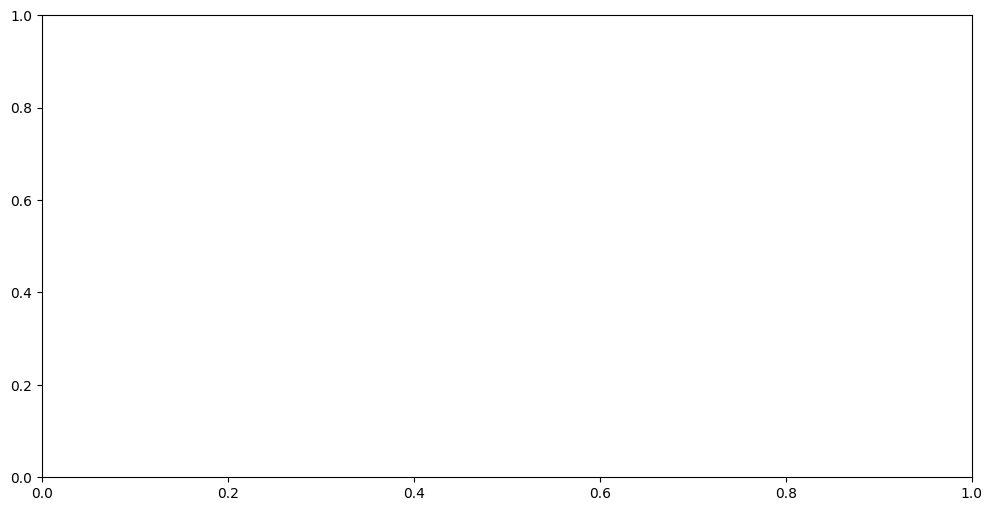

In [228]:
# fig = plt.figure(figsize=[12,6])
# ax = fig.add_subplot(111)
# ax.pcolormesh(combined_df.index, combined_df.columns, combined_df.values,
#               vmin=np.percentile(data, 1), vmax=np.percentile(data, 99.7),
#               cmap=plt.get_cmap('RdYlBu_r'), shading='auto')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_ylim(ax.get_ylim()[::-1])
# plt.show()

In [105]:
# freqs3 = data3.header.chan_freqs
# log_freqs3 = np.log10(freqs3)

# fig = plt.figure(figsize=[10,4])
# ax = fig.add_subplot(111)

# img = ax.pcolormesh(Tarray3, log_freqs3, data3,
#               norm=ImageNormalize(data3, interval=PercentileInterval(87)),
#               cmap='RdYlBu_r')

# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_ylim(ax.get_ylim()[::-1])

# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.colorbar(img, pad=0.02)
# plt.show()

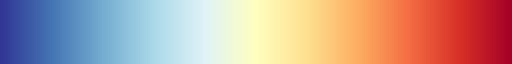

In [75]:
plt.cm.RdYlBu_r

In [94]:
data3 = np.load(f'{path}/res_0.02sec_ilofar.npy')

In [98]:
data.header.chan_freqs[0], data.header.chan_freqs[-1]

(200.0, 104.8828125)

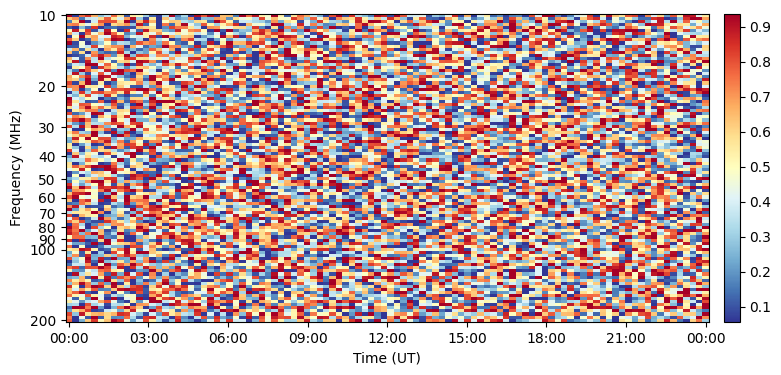

In [101]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from astropy.visualization import PercentileInterval, ImageNormalize
import numpy as np

fig = plt.figure(figsize=[10, 4])
ax = fig.add_subplot(111)

# Assuming Tarray3, freqs3, and data3 are your time, frequency, and data arrays
# Example placeholder values for Tarray3, freqs3, and data3
Tarray3 = np.linspace(0, 1, 100)  # Replace with actual time array
freqs3 = np.geomspace(10, 200, 100)  # Replace with actual frequency array in MHz
data3 = np.random.rand(100, 100)  # Replace with actual data array

# Transform the frequency array to a logarithmic scale
log_freqs3 = np.log10(freqs3)

# Create the plot using the transformed frequency values
img = ax.pcolormesh(Tarray3, log_freqs3, data3,
                    norm=ImageNormalize(data3, interval=PercentileInterval(88)),
                    cmap='RdYlBu_r')

# Set labels and limits
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set y-axis ticks and labels to match the original frequency values
freq_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]  # Adjust as necessary
log_freq_ticks = np.log10(freq_ticks)
ax.set_yticks(log_freq_ticks)
ax.set_yticklabels(freq_ticks)

fig.colorbar(img, pad=0.02)
plt.show()

1

# Import REALTA Data and Plot the Dynamic Spectrum

In [222]:
data2.shape, Tarray.shape

((488, 640869), (640869,))

In [229]:
freqs = data2.header.chan_freqs
freqs.shape

(488,)

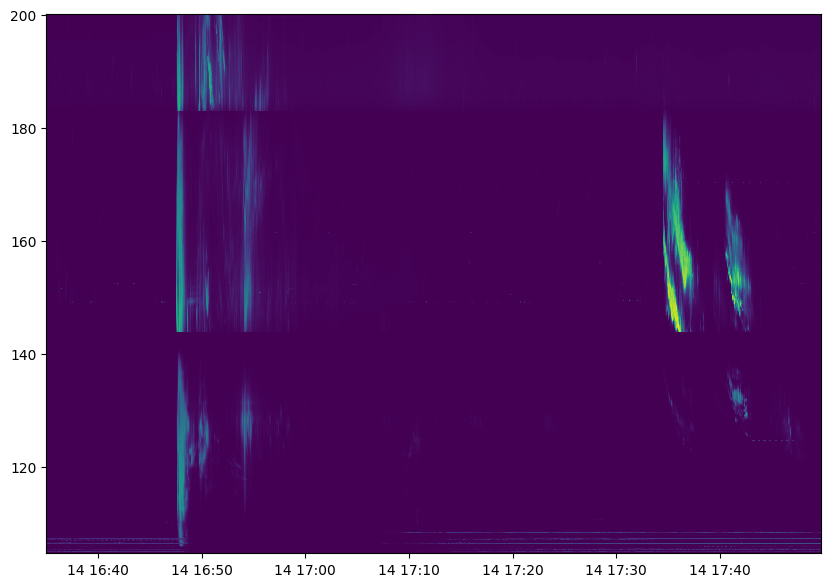

In [230]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)

ax.pcolormesh(Tarray, freqs, data2,
              norm=mageNormalize(data2, interval=PercentileInterval(98)),
              cmap='RdYlBu_r')

# plt.cm.viridis(img/img.max())

# ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1]) # Reverse the y-axis
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

In [ ]:
1